# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *Leonid*</center>

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"  
**<== задача сформулирована неявно. получается: !средняя! степень вершины по отношению к возрасту !вершин!. Возраст у каждой вершины свой. далее считаю, что задание такое: степень вершины в зависимости от возраста.**
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline
import random as rnd

#functions
#empirical CDF
def F_emp(sort_sample,x):
    i = 0
    N = len(sort_sample)
    if sort_sample[0] > x:
        return 0
    if x > sort_sample[-1]:
        return 1
    else:
        while sort_sample[i] <= x:
            i += 1
            if i >= len(sort_sample):
                break
        return (i-1.)/N

#instead of PDF
def degree_distr(k, bins = 100):
    yh, binEdges = np.histogram(k, bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return yh, bincenters

## Model A

In [2]:
def gen_regular_graph(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for j in range(1, k // 2+1):
        targets = nodes[j:] + nodes[0:j] # first j nodes are now last in list
        G.add_edges_from(zip(nodes,targets))
    return G


#model A
#m0 - number of initial nodes
#N - number of time-steps (or number new of nodes)

def Model_A(m0, N):
    
    G = gen_regular_graph(m0, 2)
    #node addition
    nodes = G.nodes()
    for node in xrange(m0, m0+N):
        G.add_node(node)
        m = rnd.randint(0, m0)
        for i in rnd.sample(nodes,m):
            G.add_edge(node,i)
        nodes.append(node)
    
    return G

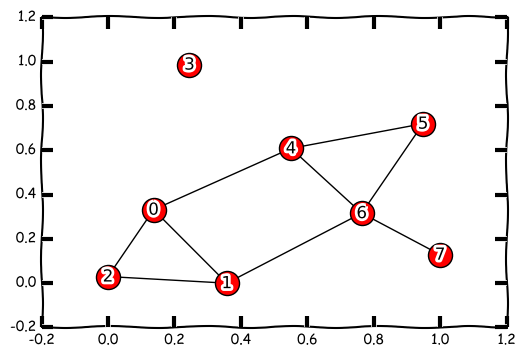

In [3]:
#example A
nx.draw_networkx(Model_A(3,5))

## Model B

I devided Model B generating on two parts: $t \leq 0.25\cdot Ne_{max}$ and $t > 0.25\cdot Ne_{max}$. Where $Ne_{max}$ - possible number of edges. It is necessary to reduce complexity (more details in the comments). 

Initial probability $p=1/N$ for all nodes. So probability of connecting with node i is: $p_i = \frac{k_i+1}{\text{sum of degrees}}$, where $k_i$ - degree of node i.

In [4]:
#Model B
#N_e - number of time-steps (or number of edges)
#N_n - total number of nodes 

def Model_B(N_n, N_e):
    
    G = nx.Graph()
    
    #nodes addition
    nodes = range(N_n)
    G.add_nodes_from(nodes)
    
    #possible number of edges
    N_e_poss = (N_n*(N_n-1))/2
    if N_e_poss < N_e:
        N_e = N_e_poss
    
    #edges addition I
    #create list of probability of attachment
    #probability of attachment depends on degree
    prob = np.ones(N_n)/N_n
    N = 0
    N_1 = min(N_e,N_e_poss/4)
    
    for i in xrange(N_1):
        
        n1 = rnd.choice(nodes)
        n2 = np.random.choice(nodes, p=prob)
        
        #!!!! this is very complex loop if we have high average degree 
        while (n1 == n2) or (G.has_edge(n1,n2) == True):
            n2 = np.random.choice(nodes, p=prob)
            
        G.add_edge(n1,n2)
        
        prob *= N_n+N
        prob[n1] += 1
        prob[n2] += 1
        N += 2
        prob /= N_n+N
    
    
    #edges addition II
    #nodes whit N_neighbors < N_nodes - 1
    nodes_iter = nodes
    
    #!!!! this is very complex loop if we have low average degree 
    for i in xrange(N_1,N_e):
        #n1 choise
        n1 = rnd.choice(nodes_iter)
        n1_neighbors = G.neighbors(n1)
        #neighbors test
        while len(n1_neighbors) == N_n-1:
            nodes_iter.remove(n1)
            n1 = rnd.choice(nodes_iter)
            n1_neighbors = G.neighbors(n1) 
            
        #list of possible nodes for connecting
        n2_nodes = [n2 for n2 in nodes_iter if (n2 not in n1_neighbors and n2 != n1)]
        deg = list(G.degree(n2_nodes).values())
        deg = np.asarray(deg)+1.
        #probability
        prob = deg/np.sum(deg)
        #n2 choise
        n2 = np.random.choice(n2_nodes, p=prob)
        G.add_edge(n1,n2)
        
    return G

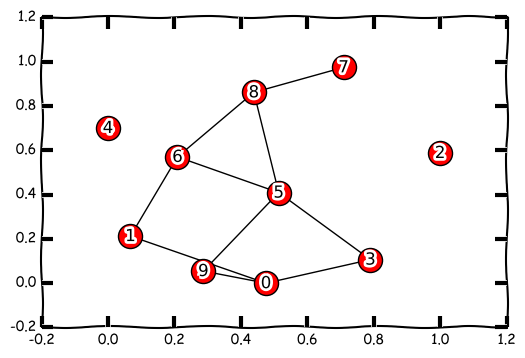

In [5]:
#example B
nx.draw_networkx(Model_B(10,10))

#### 1.1 Models generating

In [6]:
#Model A
#number of initial nodes
m0 = [1,3,5]
#number of nodes after time
N_A = 10000

#models
Models_A = [Model_A(m_in,N_A-m_in) for m_in in m0]
#degrees 
deg_A = [sorted(G.degree().values()) for G in Models_A]
#max degree
max_deg_A = max([deg[-1] for deg in deg_A])

In [7]:
#Model B
#number of nodes
N_B = 2000
#number of time steps
t_B = np.ones(3,dtype=np.int)*[1,5,7]*N_B

#models
Models_B = [Model_B(N_B,t) for t in t_B]
#degrees 
deg_B = [sorted(G.degree().values()) for G in Models_B]
#max degree
max_deg_B = max([deg[-1] for deg in deg_B])

#### 1.2 Computing CDF/PDF, describing the distribution and its properties.

A **scale-free** network is a network whose degree distribution follows a power law, at least asymptotically. We know, that **BA model** should be scale-free (https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model).

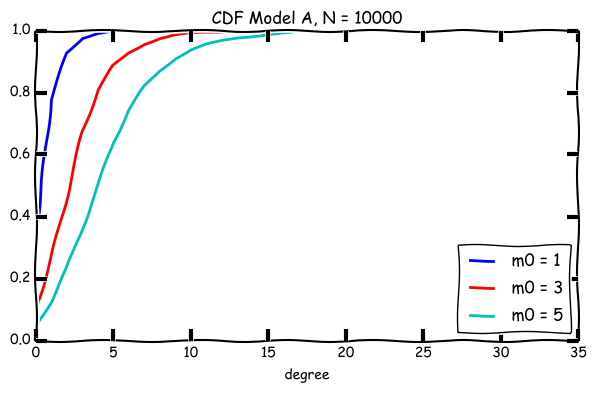

In [8]:
#Model A
#CDF
t = range(max_deg_A+1)

fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(m0)):
    deg = deg_A[i]
    def CDF(x):
        return F_emp(deg,x)
    plt.plot(t, map(CDF, t), label = 'm0 = %s' %m0[i])
ax.legend(loc='lower right')
plt.axis([0, t[-1]+1, 0, 1])
plt.xlabel('degree')
plt.title('CDF Model A, N = %s' %N_A)

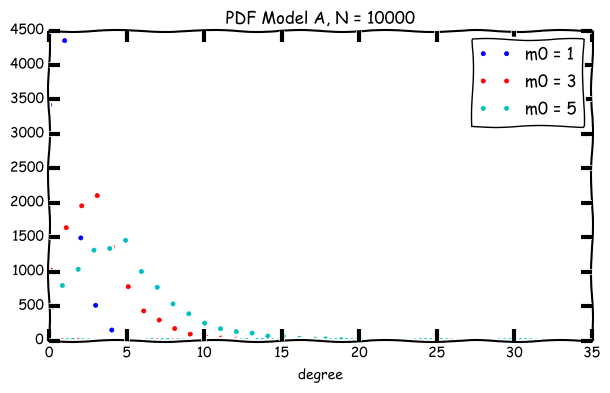

In [9]:
#PDF A
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(m0)):
    PDF = degree_distr(deg_A[i])
    plt.plot(PDF[1], PDF[0], '.',label = 'm0 = %s' %m0[i])
    
ax.legend(loc='upper right')
plt.xlabel('degree')
plt.title('PDF Model A, N = %s' %N_A)

The resulting degree distribution of Model A looks like Rayleigh distribution and, according to link below, in this limit is geometric. This fact indicating that growth alone is not sufficient to produce a scale-free structure.

https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

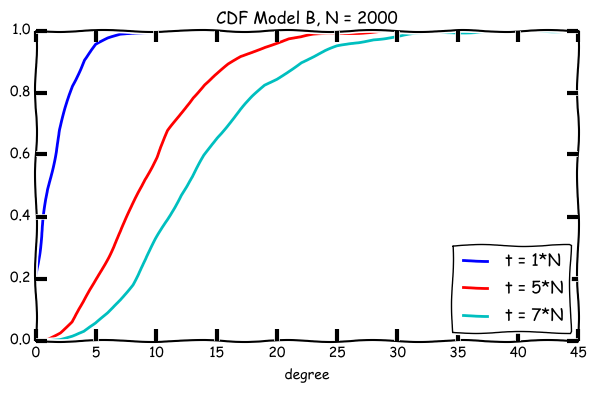

In [10]:
#Model B
#CDF
t = range(max_deg_B+1)

fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(t_B)):
    deg = deg_B[i]
    def CDF(x):
        return F_emp(deg,x)
    plt.plot(t, map(CDF, t), label = 't = %s*N' %int(t_B[i]/N_B))
ax.legend(loc='lower right')
plt.axis([0, t[-1]+1, 0, 1])
plt.xlabel('degree')
plt.title('CDF Model B, N = %s' %N_B)

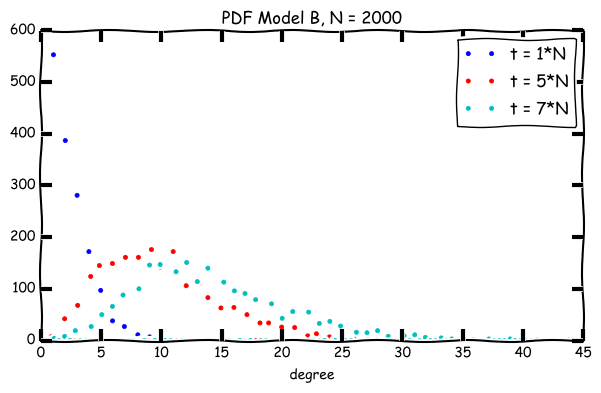

In [11]:
#PDF B
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(t_B)):
    PDF = degree_distr(deg_B[i])
    plt.plot(PDF[1], PDF[0], '.',label = 't = %s*N' %int(t_B[i]/N_B))
    
ax.legend(loc='upper right')
plt.xlabel('degree')
plt.title('PDF Model B, N = %s' %N_B)

Looks like Rayleigh distribution or nearly Gaussian as the network nears saturation. So preferential attachment alone is not sufficient to produce a scale-free structure. 

Conclusion:

The failure of models A and B to lead to a scale-free distribution indicates that growth and preferential attachment are needed simultaneously to reproduce the stationary power-law distribution observed in real networks.

#### 1.3 Illustate the dependencies

    * average path length to the number of nodes
    
Most real networks have a very short average path length leading to the concept of a small world where everyone is connected to everyone else through a very short path. As a result, most models of real networks are created with this condition in mind. One of the first models which tried to explain real networks was the random network model. It was later followed by the Watts and Strogatz model, and even later there were the scale-free networks starting with the **BA model**. All these models had one thing in common: they all predicted very short average path length (https://en.wikipedia.org/wiki/Average_path_length).

The average path length of the BA model increases approximately logarithmically with the size of the network. The actual form has a double logarithmic correction and goes as (https://en.wikipedia.org/wiki/Barabási–Albert_model):

$$  \ell \sim {\frac  {\ln N}{\ln \ln N}}$$

    * average clustering coefficient to the number of nodes
    
A graph is considered small-world, if its average local clustering coefficient is high (https://en.wikipedia.org/wiki/Clustering_coefficient). The clustering coefficient of the BA model scales with network size following approximately a power law (https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model#Clustering_coefficient):

$$C\sim N^{{-0.75}}$$ 
    
    * average node degree to the nodes "age"
According to lection 4 for BA Model:

$$k_i(t) = m \left( \frac{t}{i} \right) ^{1/2}$$

#### For model A

In [28]:
#Model A
#number of initial nodes
m0_set = [3,5,7]
#number of nodes after time
N_A = range(10,1100,100)

Models_A = []
for m0 in m0_set:
    #models
    Models_A.append([Model_A(m0,N-m0) for N in N_A])

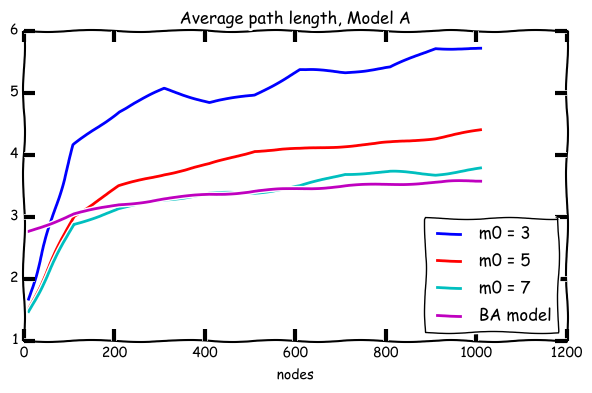

In [29]:
#average path length (APL) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(m0_set)): 
    apl = []
    for G in Models_A[i]:
        #max CC
        Gc = max(nx.connected_component_subgraphs(G), key=len)
        apl.append(nx.average_shortest_path_length(Gc))
    plt.plot(N_A, apl, '-',label = 'm0 = %s' %m0_set[i])
    
#BA model 
apl_BA = np.log(N_A)/np.log(np.log(N_A))
plt.plot(N_A, apl_BA, '-',label = 'BA model')

ax.legend(loc='lower right')
plt.xlabel('nodes')
plt.title('Average path length, Model A')

We can see increase average path length to the number of nodes in Model A. And we can see that the **APL in Model A such as
APL in B&A Model as m0 is high**.

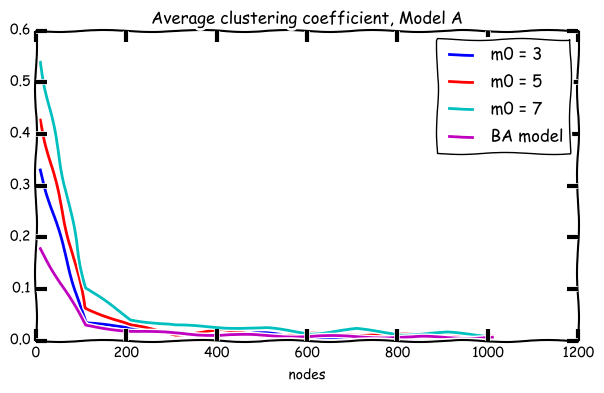

In [30]:
#average clustering coefficient (ACC) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(m0_set)): 
    acc = []
    for G in Models_A[i]:
        acc.append(nx.average_clustering(G))
    plt.plot(N_A, acc, '-',label = 'm0 = %s' %m0_set[i])
    
#BA model 
acc_BA = np.asarray(N_A)**(-0.75)
plt.plot(N_A, acc_BA, '-',label = 'BA model')
    
ax.legend(loc='upper right')
plt.xlabel('nodes')
plt.title('Average clustering coefficient, Model A')

We can see decrease average clustering coefficient to the number of nodes in Model A. This **dependence in Model A is nearly same as in BA Model**.

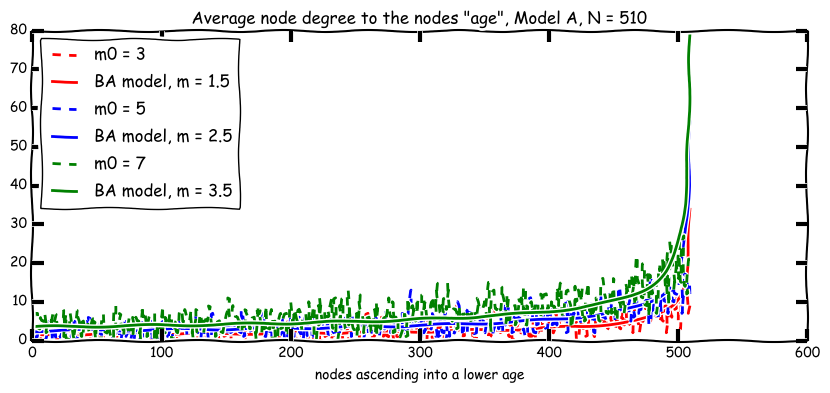

In [31]:
#average node degree to the nodes "age"
#let's take number of nodes after time
N = len(N_A)/2

fig = plt.figure(1, figsize=(10,4))
ax = plt.subplot(111)

#BA model 
deg_BA = np.arange(1,N_A[N]+1)
deg_BA = (deg_BA**(-0.5))*(float(N_A[N])**(0.5))

#colors
colors = ['red','blue','green','yellow','black']

for i in xrange(len(m0_set)): 
    G = Models_A[i][N]
    degrees = G.degree()
    nodes = sorted(degrees)
    deg = degrees.values()
    nodes_rev = nodes[::-1]
    plt.plot(nodes_rev, deg, '--',label = 'm0 = %s' %(m0_set[i]),color='%s' %colors[i])
    
    #m - RV. Distribution - U(0,m0)
    #so average m = m0/2
    m = m0_set[i]/2.
    deg_BA_m = deg_BA*m
    plt.plot(nodes_rev, deg_BA_m, '-',label = 'BA model, m = %s' %m, color='%s' %colors[i])
    
ax.legend(loc='upper left')
plt.xlabel('nodes ascending into a lower age')
plt.title('Average node degree to the nodes "age", Model A, N = %s' %N_A[N])

We can see that this dependence is same in B&A Model and Model A.

Model A is very similar to B&A Model, not to mention the degrees distribution.

#### Model B

Noticed, that for model B we should not consider dependencies on number of nodes. We should consider dependencies on some coefficient. This coefficient has been selected:
$$С_{\text{model B}} = \frac{\text{number of nodes}}{\text{possible number of nodes}} =  \frac{2\cdot N_e}{N_n \cdot (N_n-1)} 
= \frac{2\cdot t}{N_n \cdot (N_n-1)}$$

In [32]:
#Models
#number of nodes
N_n = [10,25,50]
#max possible number of edges
N_e_poss = (max(N_n)*(max(N_n)-1))/2
#bins
bins = 100
#number of time steps
t_set = np.arange(1,N_e_poss,N_e_poss/bins)
#coefficient 
coef = t_set/float(N_e_poss)

#models
Models_B = []
for N in N_n:
    Models_B.append([Model_B(N,t) for t in t_set])

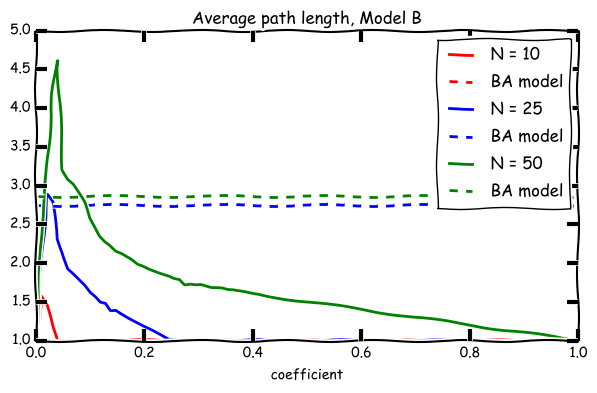

In [34]:
#average path length (APL) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

#colors
colors = ['red','blue','green','yellow','black']

for i in xrange(len(N_n)):
    apl = []
    for G in Models_B[i]:
        #max CC
        Gc = max(nx.connected_component_subgraphs(G), key=len)
        apl.append(nx.average_shortest_path_length(Gc))
    plt.plot(coef, apl, '-',label = 'N = %s' %N_n[i], color='%s' %colors[i]) 
    
    #BA model 
    apl_BA = np.log(N_n[i])/np.log(np.log(N_n[i]))
    apl_BA *= np.ones(len(t_set))
    plt.plot(coef, apl_BA, '--',label = 'BA model', color='%s' %colors[i])

ax.legend(loc='upper right')
plt.xlabel('coefficient')
plt.title('Average path length, Model B')

We can see that APL in sharply decreases as $C_{\text{model B}} \to 1$. And as number of nodes > $\approx 30$ we can find the time point that APL in Model B is such as in B&A model.

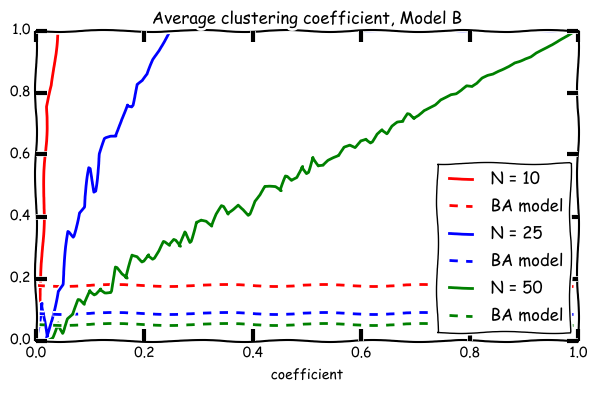

In [35]:
#average clustering coefficient (ACC) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(N_n)):
    acc = []
    for G in Models_B[i]:
        acc.append(nx.average_clustering(G))
    plt.plot(coef, acc, '-',label = 'N = %s' %N_n[i], color='%s' %colors[i])  
    
    #BA model 
    acc_BA = N_n[i]**(-0.75)
    acc_BA *= np.ones(len(t_set))
    plt.plot(coef, acc_BA, '--',label = 'BA model', color='%s' %colors[i])

    
ax.legend(loc='upper right')
plt.xlabel('nodes')
plt.title('Average clustering coefficient, Model A')

ax.legend(loc='lower right')
plt.xlabel('coefficient')
plt.title('Average clustering coefficient, Model B')

The dependence is nearly linear.

For Model B we can not illustate dependence average node degree to the nodes "age", because all of nodes have equal "age".

#### 1.4 Is scale-free property conserved in these models?

As it was said above it is not so.

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$

**<== описание не полное. нужно добавить, что каждая новая вершина имеет k случайных ребер (если она - копия, то k случайно выбранных ребер из копируемой вершины). иначе мы не получим нужных результатов**

Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

### Vertex copying model

In [19]:
#N - number of new nodes
#q - probability of copying
#k - number of edges of new node

def Model_VC(N, q, k=3, directed = False):
    
    #initial graph
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    #create initial clique (not random graph)
    #every node has k degree
    n0 = k+1
    nodes = range(n0)
    G.add_nodes_from(nodes)
    for i in xrange(0,n0-1):
        for j in xrange(i,n0):
            edge = [i,j]
            if directed:
                rnd.shuffle(edge)
            G.add_edge(edge[0],edge[1])
                
    
    #Vertex adition
    for i in xrange(n0,N):
        
        #Vertex copying
        if rnd.random() <= q:
        
            #choice of node for copying
            node = rnd.choice(nodes)
            G.add_node(i)
        
            #successors and predecessors
            pred = []
            if directed:
                pred = G.predecessors(node)
            succ_pred = list(set(G.neighbors(node)).union(set(pred)))
            for j in rnd.sample(succ_pred,k):
                G.add_edge(i,j)

            nodes.append(i)   
        
        else:
            G.add_node(i)
            for j in rnd.sample(nodes,k):
                G.add_edge(i,j)
            nodes.append(i)
            
    return G

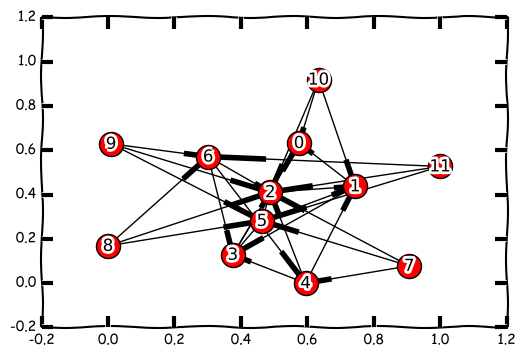

In [20]:
#example
Ex = Model_VC(12, 0.5, directed = True)
nx.draw_networkx(Ex)

#### 2.1 Generate  graphs based on the model ($N > 1000$ nodes)

In [21]:
#set of q
q_set = [0.1,0.4,0.7]
#nodes number
N_n = 1100

#models
Models_VC = [Model_VC(1100-5, q) for q in q_set]
#degrees 
deg_VC = [sorted(G.degree().values()) for G in Models_VC]
#max degree
max_deg_VC = max([deg[-1] for deg in deg_VC])

#### 2.2 Compute CDF/PDF, describe the distribution and compute\describe its properties.

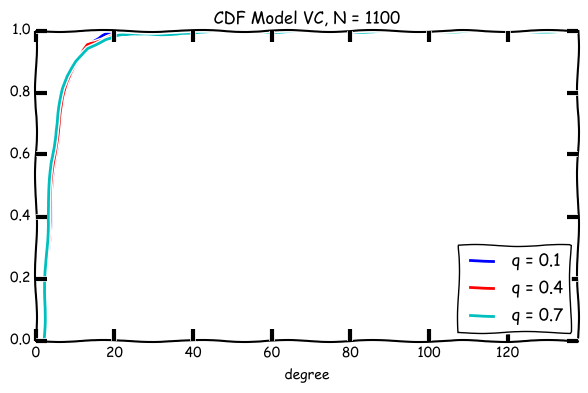

In [22]:
#CDF
t = range(max_deg_VC+1)

fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(q_set)):
    deg = deg_VC[i]
    def CDF(x):
        return F_emp(deg,x)
    plt.plot(t, map(CDF, t), label = 'q = %s' %q_set[i])
ax.legend(loc='lower right')
plt.axis([0, t[-1]+1, 0, 1])
plt.xlabel('degree')
plt.title('CDF Model VC, N = %s' %N_n)

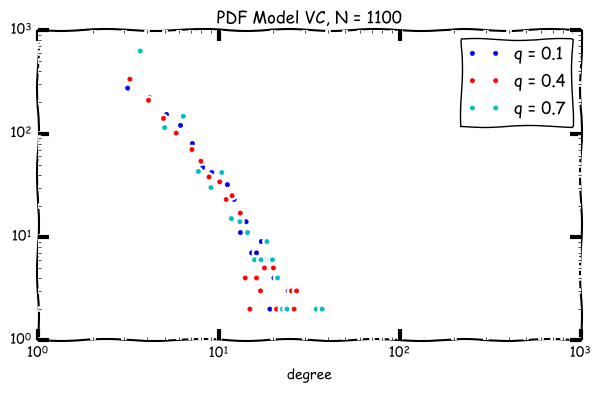

In [23]:
#PDF
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(q_set)):
    PDF = degree_distr(deg_VC[i])
    plt.loglog(PDF[1], PDF[0], '.',label = 'q = %s' %q_set[i])
    
ax.legend(loc='upper right')
plt.xlabel('degree')
plt.title('PDF Model VC, N = %s' %N_n)

Look exactly like Power Law, so this model is **scale-free**.

#### 2.3 Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

In [24]:
#Models
#q set
q_set = [0.1,0.3,0.7]
#number of nodes set
N_set = range(10,300,10)

Models_VC = []
for q in q_set:
    #models
    Models_VC.append([Model_VC(N,q) for N in N_set])

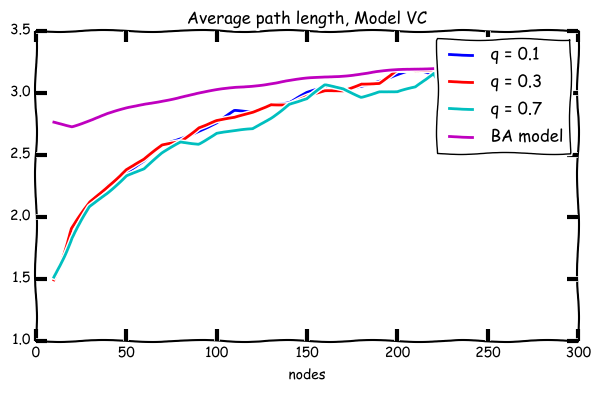

In [25]:
#average path length (APL) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(q_set)): 
    apl = []
    for G in Models_VC[i]:
        #max CC
        Gc = max(nx.connected_component_subgraphs(G), key=len)
        apl.append(nx.average_shortest_path_length(Gc))
    plt.plot(N_set, apl, '-',label = 'q = %s' %q_set[i])

#BA model 
apl_BA = np.log(N_set)/np.log(np.log(N_set))
plt.plot(N_set, apl_BA, '-',label = 'BA model')    

ax.legend(loc='upper right')
plt.xlabel('nodes')
plt.title('Average path length, Model VC')

APL in Model VC is nearly same of B&A Model.

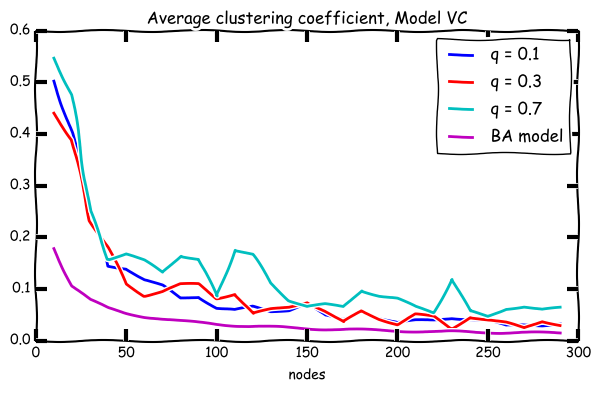

In [26]:
#average clustering coefficient (ACC) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(q_set)): 
    acc = []
    for G in Models_VC[i]:
        acc.append(nx.average_clustering(G))
    plt.plot(N_set, acc, '-',label = 'q = %s' %q_set[i])

#BA model 
acc_BA = np.asarray(N_set)**(-0.75)
plt.plot(N_set, acc_BA, '-',label = 'BA model')    

ax.legend(loc='upper right')
plt.xlabel('nodes')
plt.title('Average clustering coefficient, Model VC')

ACC in Model VC is nearly same of B&A Model.

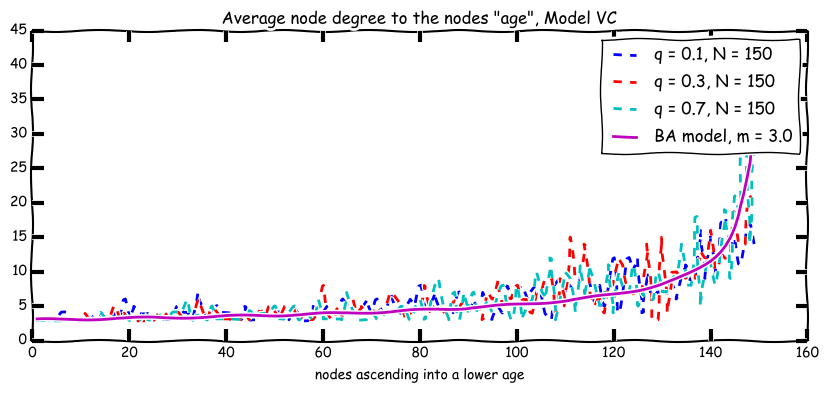

In [27]:
#average node degree to the nodes "age"
#let's take number of nodes after time
N = len(N_set)/2

#BA model 
deg_BA = np.arange(1,N_set[N]+1)
deg_BA = (deg_BA**(-0.5))*(float(N_set[N])**(0.5))

fig = plt.figure(1, figsize=(10,4))
ax = plt.subplot(111)

for i in xrange(len(q_set)): 
    G = Models_VC[i][N]
    degrees = G.degree()
    nodes = sorted(degrees)[::-1]
    deg = degrees.values()
    plt.plot(nodes, deg, '--',label = 'q = %s, N = %s' %(q_set[i],N_set[N]))
    
#BA Model
m = 3.
deg_BA_m = deg_BA*m
plt.plot(nodes_rev, deg_BA_m, '-',label = 'BA model, m = %s' %m)
    
ax.legend(loc='upper right')
plt.xlabel('nodes ascending into a lower age')
plt.title('Average node degree to the nodes "age", Model VC')

This dependence in Model VC is nearly same of B&A Model.

Conclusion:

Much like the preferential attachment mechanism, the vertex copying mechanism will tend to produce a “rich get richer” effect, as vertices with many connections to them have a higher probability that one of their neighbors will be chosen for copying, and when such an event occurs, their degree will increase.

**So, Model VC is scale-free and good B&A Model alternalive.**